In [ ]:
#CEL PROJEKTU: CELEM PROJEKTU JEST SPRAWDZENIE STOPNIA SKUTECZNOŚCI WYBRANYCH MODELI/ALGORYTMÓW UCZENIA MASZYNOWEGO 
#DO PRZEWIDYWANIA WARTOŚCI DANYCH SZEREGU CZASOWEGO NA PODSTAWIE SPÓŁKI AKCYJNEJ GOOGLE/ALPHABET

#WYBRAŁEM TĄ SPÓŁKĘ, PONIEWAŻ JEST TO NAJWIĘKSZA TECHNOLOGICZNA FIRMA NA ŚWIECIE I OSOBIŚCIE POSIADAM JĄ W SWOIM PORTFELU INWESTYCYJNYM

In [ ]:
pip install yfinance

In [976]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import yfinance as yf

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn import  metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [977]:
# IMPORT DANYCH Z WYKORZYSTANIEM YFINANCE

data = yf.download('GOOGL', index_col = 0, squeeze = True, parse_dates=['Date'])

#WYSWIETLENIE DANYCH

data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2023-01-18,92.139999,92.800003,90.639999,91.120003,91.120003,29116700
2023-01-19,90.720001,93.610001,90.629997,93.050003,93.050003,37000400
2023-01-20,95.099998,98.300003,95.019997,98.019997,98.019997,63037300


In [978]:
#WNIOSEK: KOLUMNY W ZAIMPORTOWANYCH REPREZENTUJĄ ODPOWIEDNIO: CENĘ OTWARCIA W DANEJ SESJI, MAKSYMALNĄ CENĘ PODCZAS TRWANIA SESJI, MINIMALNĄ CENĘ W DANEJ SESJI, CENĘ ZAMKNIĘCIA W DANEJ SESJI ORAZ WOLUMEN TRANSAKCYJNY, WIERSZE/INDEKSY REPREZENTUJĄ DZIEŃ HANDLOWY


In [979]:
#WYŚWIETLENIE WYMIARÓW DANYCH

data.shape

(4640, 6)

In [980]:
#WNIOSEK: DANE SKŁADAJĄ SIĘ Z 6CIU KOLUMN ORAZ 4629 OBSERWACJI

In [981]:
#SPRAWDZENIE CZY W DANYCH ZNAJDUJĄ SIĘ BRAKUJĄCE WARTOŚCI

data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [982]:
#WNIOSEK: ZAIMPORTOWANE DANE SĄ CZYSTE - NIE WYSTĘPUJĄ WARTOŚCI BRAKUJĄCE

In [983]:
#FILTROWANIE ANALIZOWANYCH DANYCH - NAS INTERESUJE CENA ZAMKNIECIA

data = data['Close']

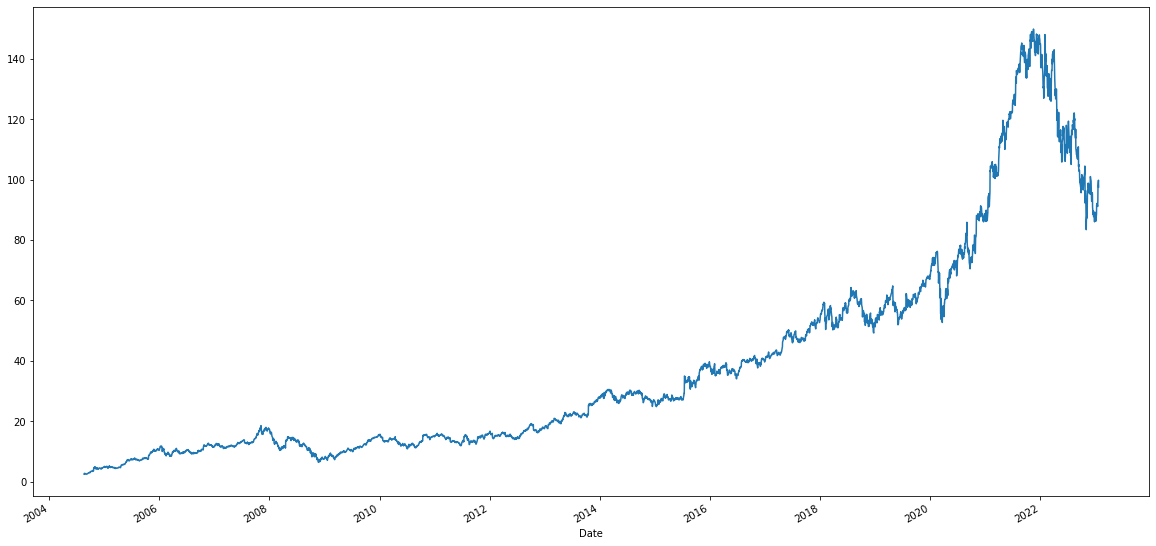

In [984]:
#NARYSOWANIE WYKRESU CENY ZAMKNIECIA W CZASIE

plt.figure(figsize=(20, 10))
data.plot()
plt.show()

In [985]:
from statsmodels.tsa.stattools import adfuller

In [986]:
#ZAIMPORTOWANIE FUNKCJI SPRAWDZAJĄCEJ STACJONARNOŚĆ SZEREGU CZASOWEGO

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()#.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(20,10));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

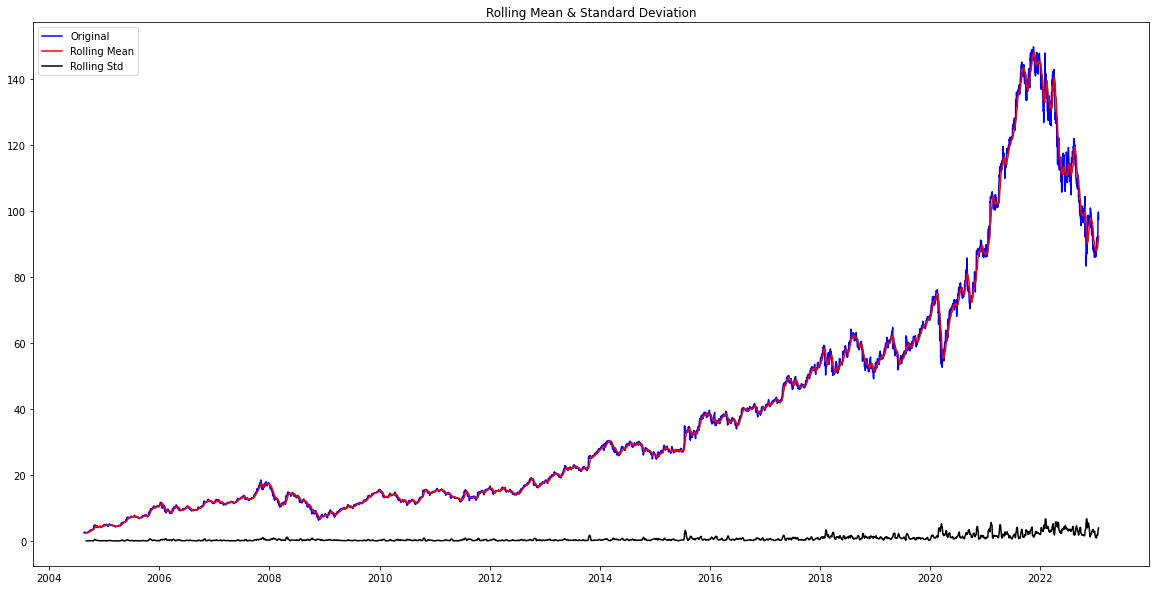

Results of Dickey-Fuller Test:
Test Statistic                   -0.092420
p-value                           0.950188
#Lags Used                       23.000000
Number of Observations Used    4616.000000
Critical Value (1%)              -3.431767
Critical Value (5%)              -2.862166
Critical Value (10%)             -2.567103
dtype: float64


In [987]:
#SPRAWDZENIE STACJONARNOŚCI SZEREGU CZASOWEGO

test_stationarity(data)

In [988]:
#SPRAWDZENIE P-VALUE

_,pval,_,_,_,_ =adfuller(data, autolag='AIC')
pval

0.9501883559135591

In [989]:
#SPRAWDZENIE P-VALUE

if pval > 0.05:
    print('pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny')
else:
    print('pval < 0.05 -> odrzucamy hipoteze zerowa -> szereg czasowy jest stacjonarny')

pval > 0.05 -> przyjmujemy hipoteze zerowa -> szereg czasowy jest niestacjonarny


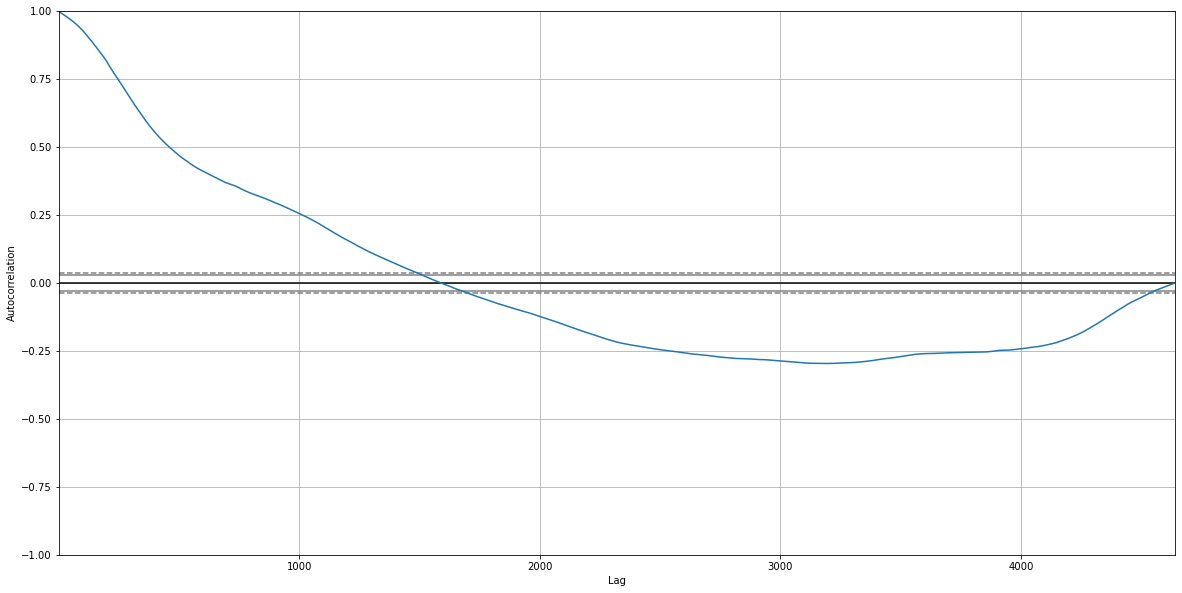

In [990]:
#SPRAWDZENIE AUTOKORELACJI

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10));
autocorrelation_plot(data)
plt.show()

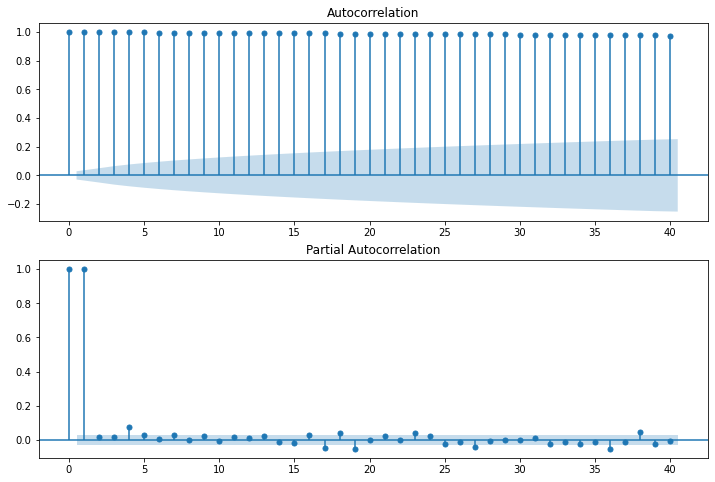

In [991]:
#SPRAWDZENIE AUTOKORELACJI

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values, lags=40, ax=ax2)
plt.show()

In [992]:
#DEFINIOWANIE SCALER

scaler=MinMaxScaler(feature_range=(0,1))

data_scaled = scaler.fit_transform(data.values.reshape(-1,1))

In [993]:
#DEFINIOWANIE ROZMIARU CZĘŚCI TESTOWEJ DANYCH

test_size = 0.2

In [994]:
#PODZIAŁ DANYCH NA CZĘŚĆ TRENINGOWĄ I TESTOWĄ

training_data_size = int(len(data_scaled)*(1-test_size))
test_data_size = len(data_scaled)-training_data_size

train_data = data_scaled[0:training_data_size,:]
test_data = data_scaled[training_data_size:len(data_scaled),:1]

In [995]:
#DEFINIOWANIE PARAMETRU TIME_STEP CZYLI ILOŚCI OBSERWACJI "WSTECZNYCH" NA PODSTAWIE KTÓRYCH BĘDZIEMY PRZEWIDYWAĆ OBSERWACJĘ "PRZYSZŁĄ"

time_step = 5

In [996]:
def create_dataset(dataset, time_step=time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [997]:
#DEFINIOWANIE SIECI NEURONOWEJ LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer ='adam', metrics=['mse', 'mae'])

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
223/223 [==============================] - 12s 19ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0215 - val_loss: 1.3986e-04 - val_mse: 1.3986e-04 - val_mae: 0.0089
Epoch 2/30
223/223 [==============================] - 3s 12ms/step - loss: 1.6335e-04 - mse: 1.6335e-04 - mae: 0.0088 - val_loss: 2.3145e-04 - val_mse: 2.3145e-04 - val_mae: 0.0131
Epoch 3/30
223/223 [==============================] - 3s 12ms/step - loss: 1.6900e-04 - mse: 1.6900e-04 - mae: 0.0091 - val_loss: 1.2622e-04 - val_mse: 1.2622e-04 - val_mae: 0.0086
Epoch 4/30
223/223 [==============================] - 3s 12ms/step - loss: 1.5019e-04 - mse: 1.5019e-04 - mae: 0.0085 - val_loss: 1.5130e-04 - val_mse: 1.5130e-04 - val_mae: 0.0103
Epoch 5/30
223/223 [==============================] - 3s 11ms/step - loss: 1.3808e-04 - mse: 1.3808e-04 - mae: 0.0082 - val_loss: 1.1950e-04 - val_mse: 1.1950e-04 - val_mae: 0.0084
Epoch 6/30
223/223 [==============================] - 2s 11ms/step - loss: 1.2247e-04 - mse: 1.2247e-0

In [998]:
# PRZEWIDYWANIE DANYCH Z CZĘŚCI TESTOWYCH MODELEM LSTM

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

29/29 [==============================] - 0s 4ms/step


In [999]:
#TRANSFORMACJA DANYCH W CELU POPRAWNEGO WYSWIETLENIA NA WYKRESIE

train_predict_inverted = scaler.inverse_transform(train_predict)
test_predict_inverted = scaler.inverse_transform(test_predict)

train_predict_inverted_zeros = np.zeros(time_step+1)
train_predict_inverted_final = np.insert(train_predict_inverted, 0, train_predict_inverted_zeros)

test_predict_inverted_zeros = np.zeros(train_predict_inverted_final.shape[0]+ time_step+1)
test_predict_inverted_final= np.insert(test_predict_inverted, 0, test_predict_inverted_zeros)

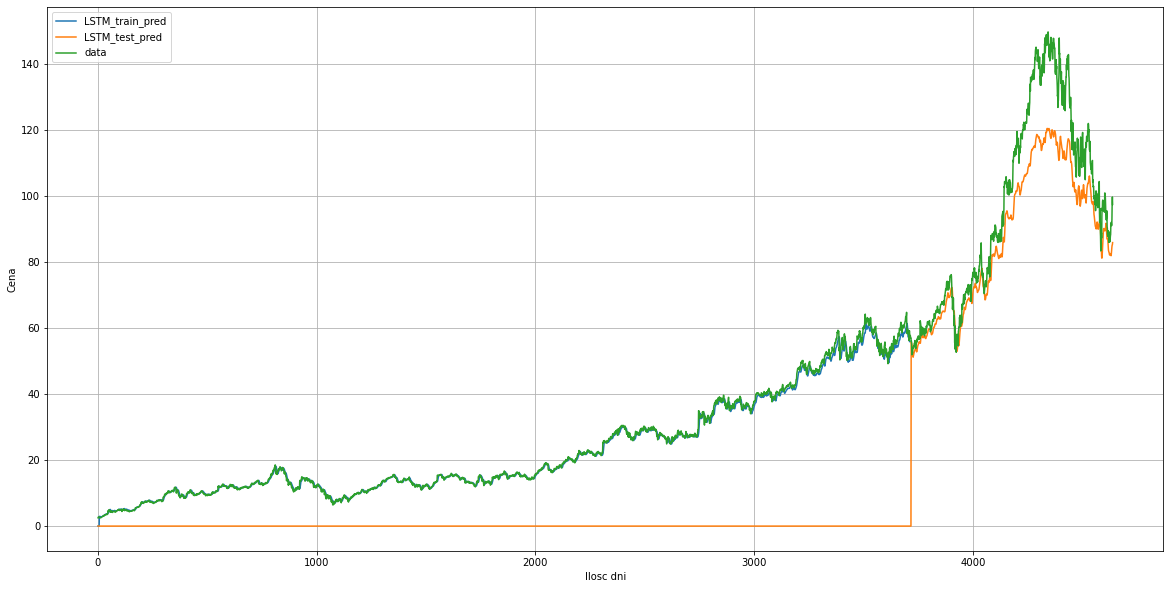

In [1000]:
#WYKRES CALOSCI DANYCH ORAZ PRZEWIDYWAN ZA POMOCĄ LSTM DLA CZĘŚCI TRENINGOWEJ I TESTOWEJ

plt.figure(figsize=(20,10))

plt.plot(train_predict_inverted_final, label='LSTM_train_pred')
plt.plot(test_predict_inverted_final, label = 'LSTM_test_pred')
plt.plot(data.values, label= 'data')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

In [1001]:
#OBLICZENIE METRYK JAKOŚCIOWYCH DLA PRZEWIDYWANIA Z DANYCH TESTOWYCH DLA LSTM

lstm_mean_squared_error = metrics.mean_squared_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_mean_absolute_error = metrics.mean_absolute_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_median_absolute_error = metrics.median_absolute_error(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_explained_variance_score = metrics.explained_variance_score(test_predict_inverted, data.values[-test_data_size+time_step+1:])

lstm_r2 = metrics.r2_score(test_predict_inverted, data.values[-test_data_size+time_step+1:])

In [1002]:
#UTWORZENIE DATAFRAME Z METRYKAMI JAKOSCIOWYMI

d_1 = {'r2': [lstm_r2],
     'explained_variance_score': [lstm_explained_variance_score], 
     'median_absolute_error': [lstm_median_absolute_error],
     'mean_squared_error' : [lstm_mean_squared_error],
     'mean_absolute_error' : [lstm_mean_absolute_error],
    }

df_1 = pd.DataFrame(data=d_1)
df_1.insert(loc=0, column='Method', value=['LSTM'])

df_1

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,0.628434,0.844639,6.954735,168.815359,10.06314


In [1003]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [1004]:
#PODZIAŁ DANYCH PRZED TRANSFORMACJĄ NA CZĘŚĆ TRENINGOWĄ ORAZ TESTOWĄ

data_values = data.values
data_train = data[:-test_data_size]
data_test = data[-test_data_size:]

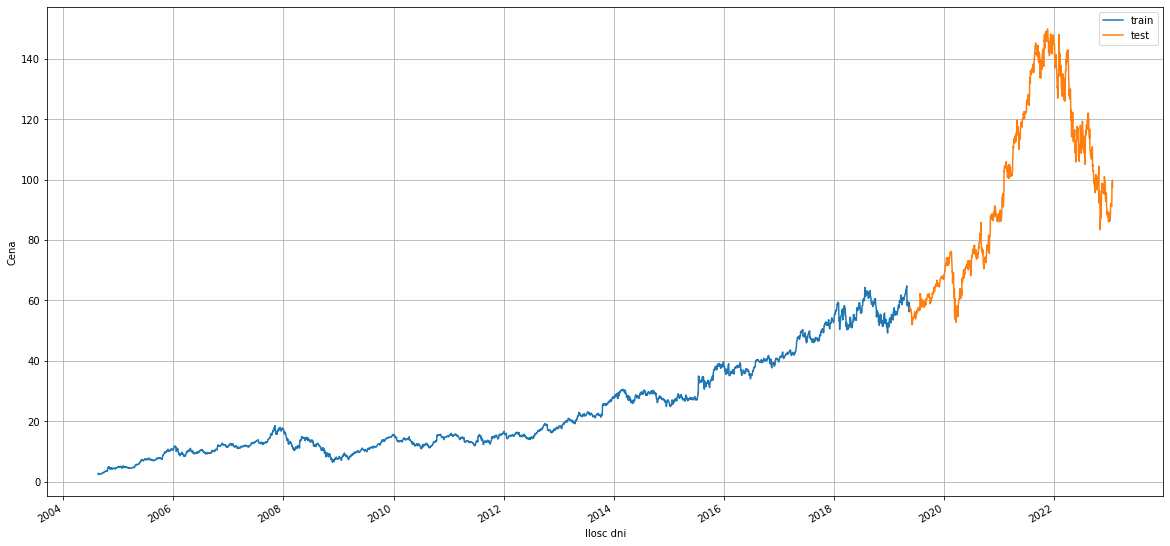

In [1005]:
#NARYSOWANIE WYKRESU DLA DANYCH Z CZĘŚCI TRENIGOWEJ ORAZ TESTOWEJ PRZED TRANSFORMACJĄ

plt.figure(figsize=(20, 10))

data_train.plot(label = 'train')
data_test.plot(label = 'test')

plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

In [1006]:
#TRANSFORMACJA ZAIMPORTOWANYCH DANYCH SZEREGU CZASOWEGO

df = pd.DataFrame()
df['t'] = [x for x in data]
dataframe = series_to_supervised(df, time_step)
dataframe

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,2.511011,2.710460,2.737738,2.624374,2.652653,2.700450
6,2.710460,2.737738,2.624374,2.652653,2.700450,2.656406
7,2.737738,2.624374,2.652653,2.700450,2.656406,2.552803
8,2.624374,2.652653,2.700450,2.656406,2.552803,2.561812
9,2.652653,2.700450,2.656406,2.552803,2.561812,2.508759
...,...,...,...,...,...,...
4635,88.419998,91.519997,91.129997,92.120003,91.290001,91.120003
4636,91.519997,91.129997,92.120003,91.290001,91.120003,93.050003
4637,91.129997,92.120003,91.290001,91.120003,93.050003,98.019997
4638,92.120003,91.290001,91.120003,93.050003,98.019997,99.790001


In [1007]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [1008]:
#PODZIAŁ DANYCH NA CZĘŚĆ TESTOWĄ ORAZ TRENINGOWĄ

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [1009]:
#DEFINIOWANIE PARAMETRÓW CROSS-VALIDATION

seed=123
kfold = model_selection.KFold(n_splits=5, random_state=None)

In [1010]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ ELASTIC NET
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.5068282805537, tolerance: 367.5657626552545
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603.7620978781156, tolerance: 356.25712200981087
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586.9118971021567, tolerance: 361.5829291566687
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4915.2378146174815, tolerance: 374.24732241479893
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4922.739357212078, tolerance: 367.5657626552545
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4645.107690396524, tolerance: 356.25712200981087
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6188.584680622785, tolerance: 361.5829291566687
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6024.799305816547, tolerance: 357.3829707987056
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6266.019973792045, tolerance: 374.24732241479893
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

{'elasticnet__alpha': 1, 'polynomialfeatures__degree': 2}

In [1011]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ LASSO
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.4570439571944, tolerance: 367.5657626552545
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.3734539666916, tolerance: 356.25712200981087
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.3470699627546, tolerance: 361.5829291566687
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7002.089714268629, tolerance: 374.24732241479893
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7400.454310785703, tolerance: 367.5657626552545
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7127.346692665274, tolerance: 356.25712200981087
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9523.58016409594, tolerance: 361.5829291566687
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9342.471765228936, tolerance: 357.3829707987056
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9607.25354411529, tolerance: 374.24732241479893
  model = cd_fast.enet_coordinate_descent(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conver

{'lasso__alpha': 1, 'polynomialfeatures__degree': 2}

In [1012]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ RIDGE
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ANALIZOWANY WSPÓŁCZYNNIK ALFA: 0.01, 0.1, 1, 10
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, max_iter=1000, random_state=seed)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [1, 2, 3]},
                    cv=kfold,
                    refit=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.54003e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.64312e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.57407e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.62592e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41595e-17): result may 

{'polynomialfeatures__degree': 1, 'ridge__alpha': 3}

In [1013]:
#WYSZUKIWANIE OPTYMALNEGO STOPNIA WIELOMIANU METODĄ REGRESJI WIELOMIANOWEJ
#ANALIZOWANE STOPNIE WIELOMIANU: OD 1 DO 4
#ZWRACANIE OPTYMALNEGO STOPNIA WIELOMIANU

grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'polynomialfeatures__degree': 1}

In [1014]:
#TRENOWANIE MODELU MLP REGRESSOR 

grid_5 = GridSearchCV(MLPRegressor(hidden_layer_sizes=(100,100,100),activation='tanh',alpha=0.0001,max_iter=1000),
                    param_grid={'hidden_layer_sizes': [(1000,1000,1000),(100,100,100),(10,10,10)],
                                'alpha': [1, 10, 100 ,1000],
                               'activation': ['identity', 'logistic', 'tanh', 'relu']                               
                               },
                    cv = kfold,
                    n_jobs=1,
                    refit=True)

grid_5.fit(X_train,y_train)
grid_5.best_params_

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\ne

C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Krzysiek\anaconda3\lib\site-packages\sklearn\ne

{'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (100, 100, 100)}

In [1015]:
#UTWORZENIE LIST OPTYMALNYCH PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('MLP_R', grid_5.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []

for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

print('LSTM')
print("R^2: {}".format(lstm_r2))
print("Explained variance score: {}".format(lstm_explained_variance_score))
print("Median absolute error: {}".format(lstm_median_absolute_error))
print("Mean squared error: {}".format(lstm_mean_absolute_error))
print("Mean absolute errors: {}".format(lstm_mean_absolute_error))

ElasticNet
R^2: 0.9991588424433641
Explained variance score: 0.9991588517152543
Median absolute error: 0.31461513098425087
Mean squared error: 1.0477988793435238
Mean absolute errors: 0.5876824409946797
Lasso
R^2: 0.9991577961679626
Explained variance score: 0.9991578116006247
Median absolute error: 0.3250035445223389
Mean squared error: 1.0491021859410412
Mean absolute errors: 0.5914781467694094
Ridge
R^2: 0.9992686200743117
Explained variance score: 0.9992686776953495
Median absolute error: 0.1962600769699545
Mean squared error: 0.9110529418239446
Mean absolute errors: 0.4805373223810444
LR
R^2: 0.9992686360388627
Explained variance score: 0.9992686938020094
Median absolute error: 0.19615766754979802
Mean squared error: 0.9110330553727661
Mean absolute errors: 0.48050190559511174
MLP_R
R^2: 0.9991799636131606
Explained variance score: 0.9992121384034789
Median absolute error: 0.22404353898224905
Mean squared error: 1.0214890187607308
Mean absolute errors: 0.5234457995039955
LSTM
R^2:

In [1016]:
#UTWORZENIE DATAFRAME PARAMETRÓW R^2, VAR, MAE, MSE DLA WSZYSTKICH ANALIZOWANYCH METOD

d_2 = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }

df_2 = pd.DataFrame(data=d_2)
df_2.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge', 'LR', 'MLP_R'])

df_2

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.999159,0.999159,0.314615,1.047799,0.587682
1,Lasso,0.999158,0.999158,0.325004,1.049102,0.591478
2,Ridge,0.999269,0.999269,0.196260,0.911053,0.480537
3,LR,0.999269,0.999269,0.196158,0.911033,0.480502
4,MLP_R,0.999180,0.999212,0.224044,1.021489,0.523446


In [1017]:
#WYSWIETLENIE POPRZEDNIO UTWORZONEGO DATAFRAME Z METRYKAMI JAKOSCIOWYMI DLA SIECI NEURONOWEJ LSTM

df_1

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,0.628434,0.844639,6.954735,168.815359,10.06314


In [1018]:
#WYSWIETLENIE POPRZEDNIO UTWORZONEGO DATAFRAME Z METRYKAMI JAKOSCIOWYMI DLA POZOSTALYCH ANALIZOWANYCH MODELI

df_2

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.999159,0.999159,0.314615,1.047799,0.587682
1,Lasso,0.999158,0.999158,0.325004,1.049102,0.591478
2,Ridge,0.999269,0.999269,0.196260,0.911053,0.480537
3,LR,0.999269,0.999269,0.196158,0.911033,0.480502
4,MLP_R,0.999180,0.999212,0.224044,1.021489,0.523446


In [1022]:
#POŁĄCZENIE DWÓCH DATAFRAME Z METRYKAMI JAKOSCIOWYMI

df = pd.concat([df_1, df_2])

df

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,LSTM,0.628434,0.844639,6.954735,168.815359,10.063140
0,ElasticNet,0.999159,0.999159,0.314615,1.047799,0.587682
1,Lasso,0.999158,0.999158,0.325004,1.049102,0.591478
2,Ridge,0.999269,0.999269,0.196260,0.911053,0.480537
3,LR,0.999269,0.999269,0.196158,0.911033,0.480502
4,MLP_R,0.999180,0.999212,0.224044,1.021489,0.523446


In [1024]:
#FILTROWANIE DATAFRAME DLA MAKSYMALNEJ WARTOŚCI R^2 ODPOWIADAJĄCEJ NAJSKUTECZNIEMU MODELOWI/ALGORYTMOWI MAKSYMALNEJ WARTOŚCI R^2

df[df['r2'] == df['r2'].max()]

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
3,LR,0.999269,0.999269,0.196158,0.911033,0.480502


In [1025]:
#TRANSFORMACJA DANYCH W CELU POPRAWNEGO POKAZANIA NA WYKRESIE

data_train_zeros = np.zeros(data_train.values.shape[0])
data_test_chart= np.insert(data_test.values, 0, data_train_zeros)

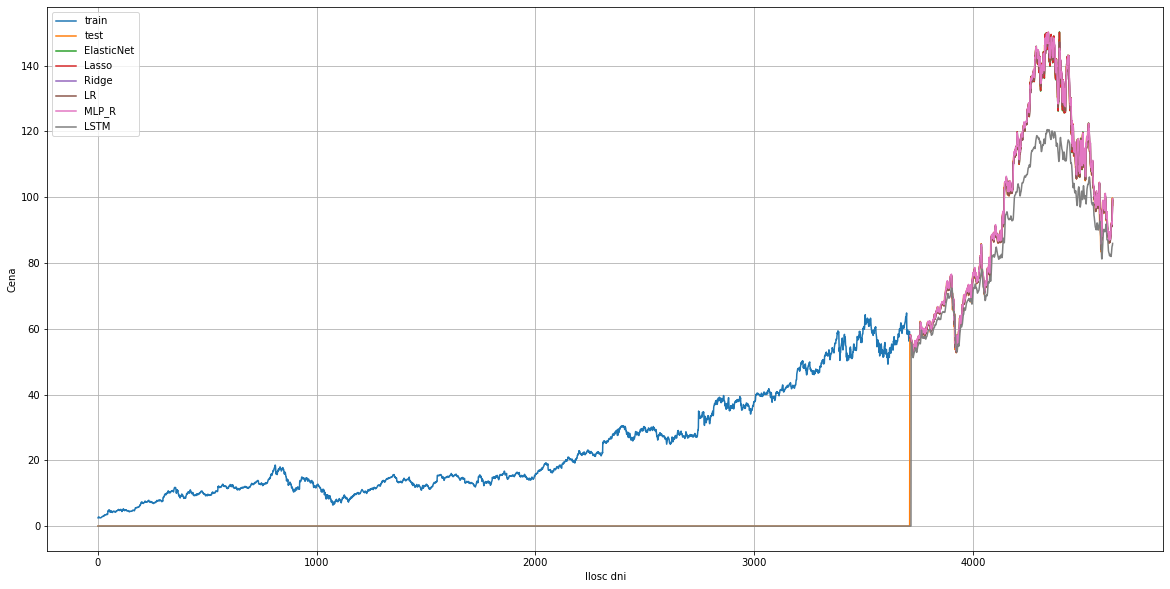

In [1026]:
# NARYSOWANIE WYKRESU CZĘŚCI TRENINGOWEJ, TESTOWEJ ORAZ WSZYSTKICH NAUCZONYCH MODELI - MODELE PRZEWIDUJĄ OSTATNIE 925 OBSERWACJI Z CZĘŚCI TESTOWEJ

plt.figure(figsize=(20,10))
plt.plot(data_train.values, label = 'train')
plt.plot(data_test_chart, label = 'test')

all_data = []

for name, model in models: 
    data = np.zeros(data.shape[0], dtype=float)
    data.fill(np.nan)
    
    for i in range(1,test_data_size):
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
        
    all_data.append(data)
        
    plt.plot(data , label=name)
    
    
plt.plot(test_predict_inverted_final, label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc dni')
plt.ylabel('Cena')
plt.show()

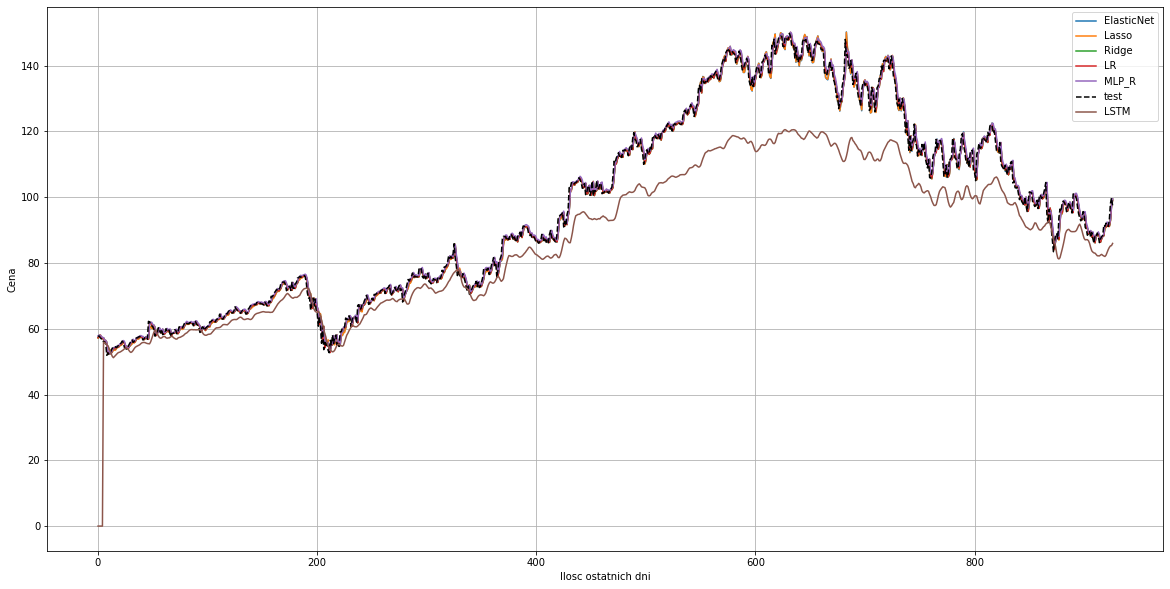

In [1027]:
# NARYSOWANIE WYKRESU DLA CZĘŚCI TESTOWEJ NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,test_data_size):
        data_chart = data_test.values
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

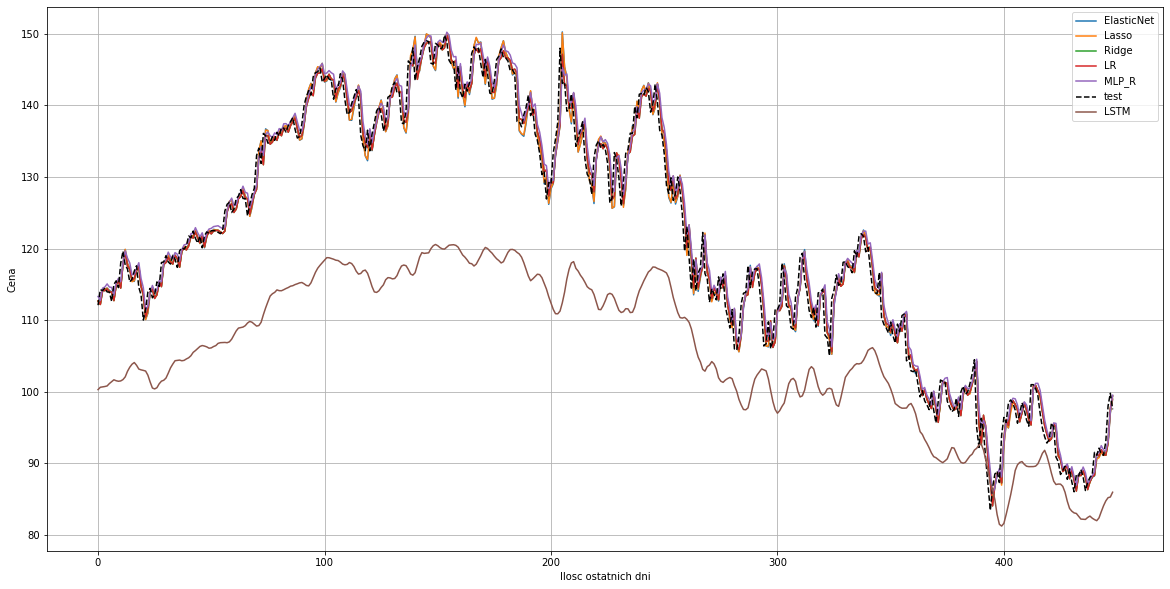

In [1028]:
# NARYSOWANIE WYKRESU OSTATNICH 450 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,450):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

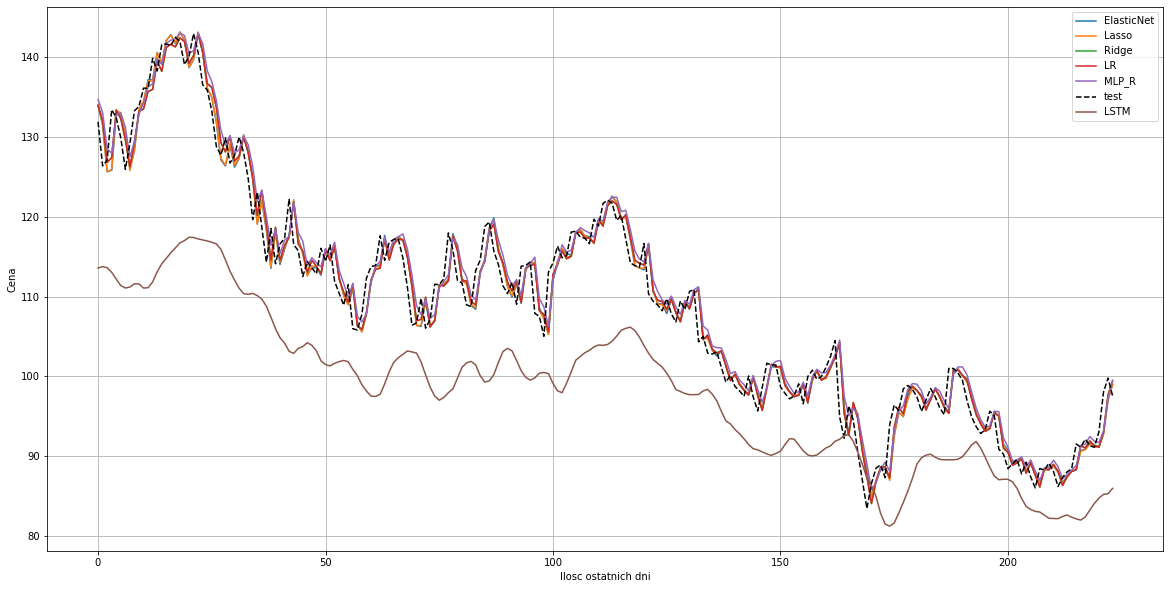

In [1029]:
# NARYSOWANIE WYKRESU OSTATNICH 225 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,225):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

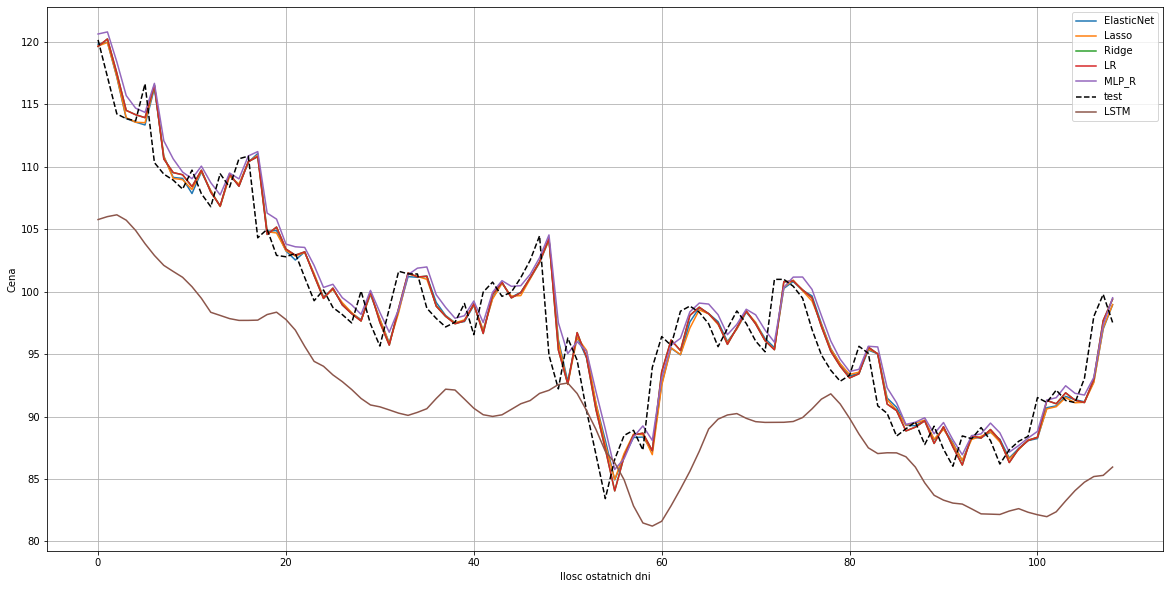

In [1030]:
# NARYSOWANIE WYKRESU OSTATNICH 110 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,110):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

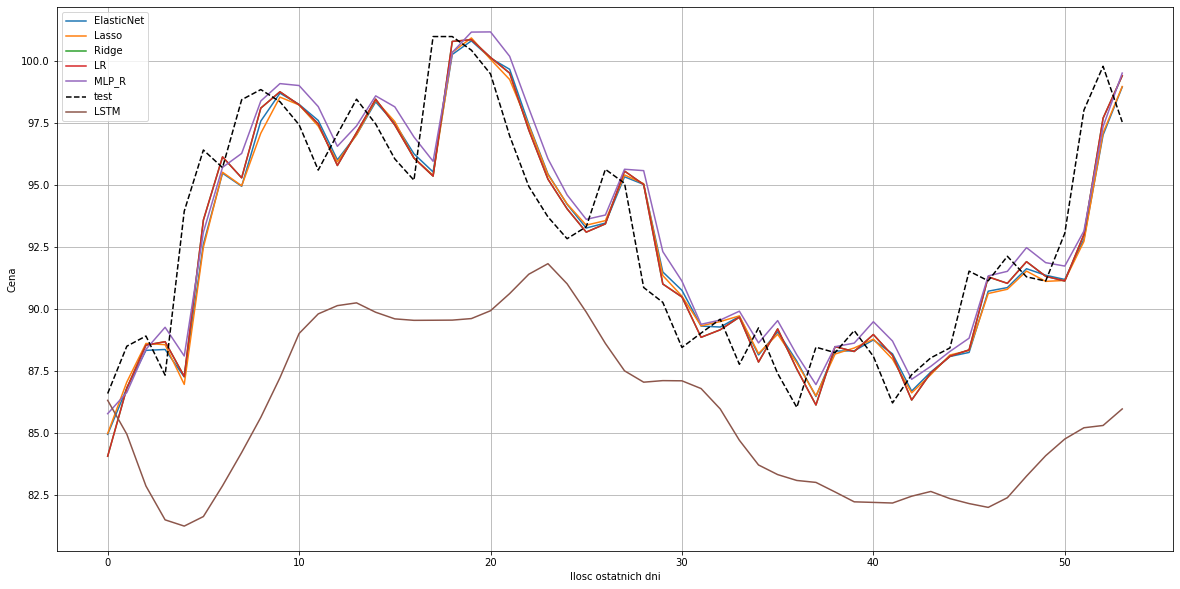

In [1031]:
# NARYSOWANIE WYKRESU OSTATNICH 55 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,55):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

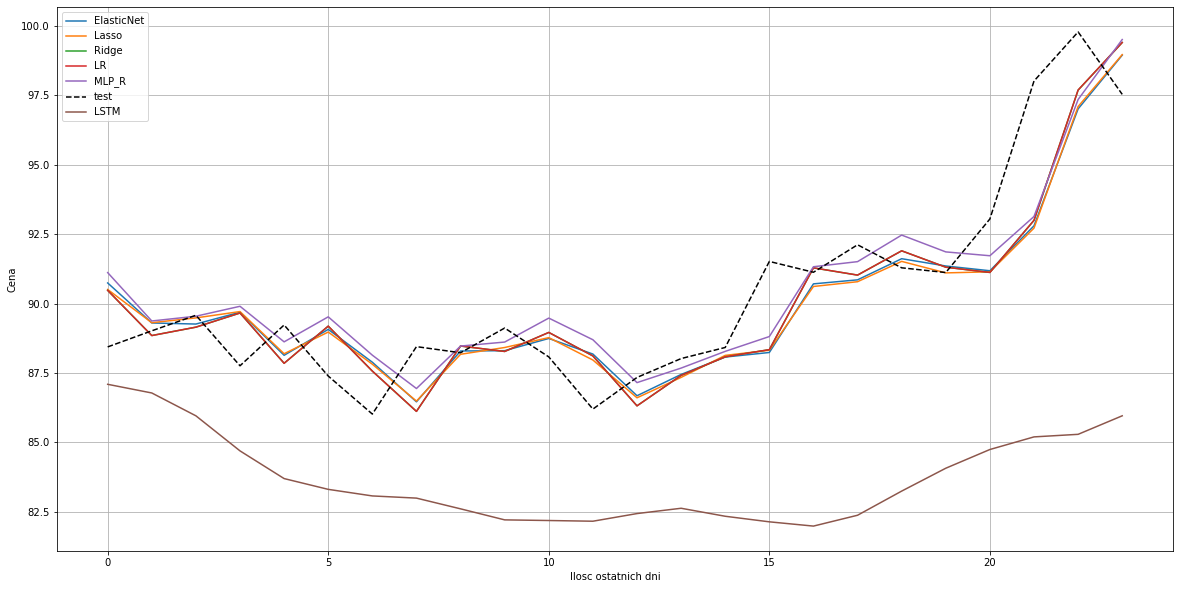

In [1032]:
# NARYSOWANIE WYKRESU OSTATNICH 25 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,25):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

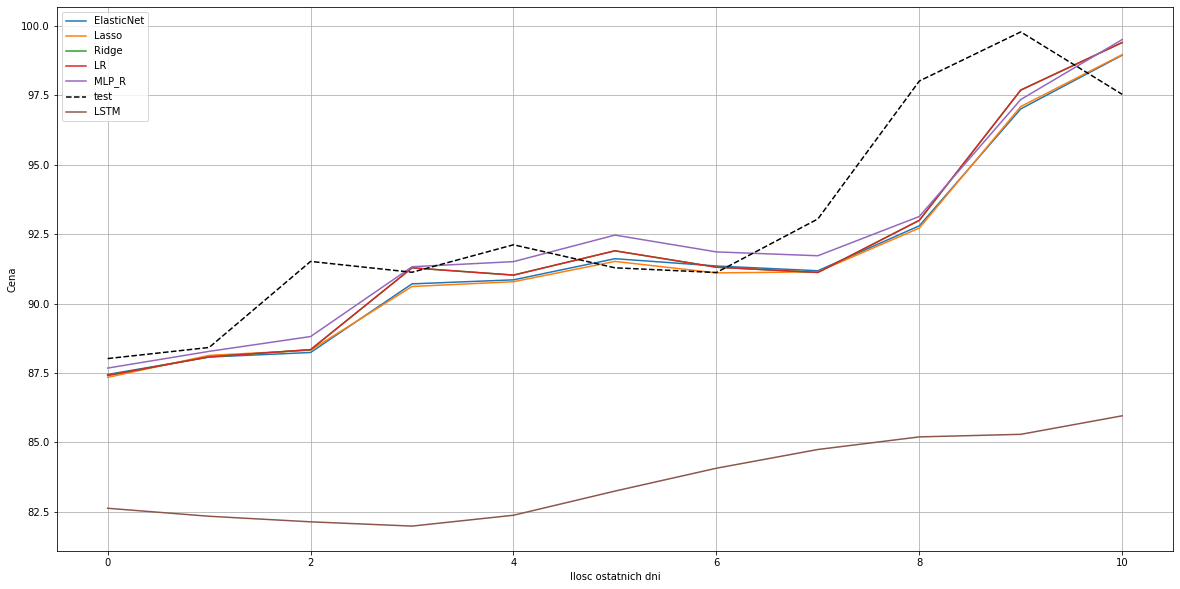

In [1033]:
# NARYSOWANIE WYKRESU OSTATNICH 12 OBSERWACJI DLA NAUCZONYCH MODELI

plt.figure(figsize=(20,10))

for name, model in models: 
    
    for i in range (1,12):
        data_chart = data_test.values
    
        point = np.array([data_values[ (data_values.shape[0]-((time_step+1*i))):(data_values.shape[0]-(1*i))]])
        pre=model.predict(point)
        data[-i]=pre
       
    plt.plot( data[-i:] , label=name)

plt.plot(data_chart[-i:], 'k--', label='test')
plt.plot(test_predict_inverted_final[-i:], label='LSTM')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Ilosc ostatnich dni')
plt.ylabel('Cena')
plt.show()

In [1035]:
#WNIOSEK_1: POMIMO, IŻ ANALIZOWANE MODELE W SPOSÓB SATYSFAKCJONUJĄCY PRZEWIDUJĄ OBSERWACJE DLA DANYCH Z CZĘŚCI TESTOWEJ, 
        #NALEŻY PAMIĘTAĆ, IŻ MODEL PRZEWIDUJE WARTOŚCI NA PODSTAWIE OBSERWACJI Z DNIA POPRZEDNIEGO, 
        #MODEL JEST WRAŻLIWY NA WYDARZENIA NIESPODZIEWANE MAJĄCE NISKIE PRAWDOPODOBIEŃSTWO ORAZ WPROWADZAJĄCE DUŻĄ ZMIENNOŚĆ ANALIZOWANEGO WALORU/SPÓŁKI TZW. CZARNE ŁABĘDZIE

In [ ]:
#WNIOSEK_2: SIEĆ NEURONOWA LSTM POMIMO, IŻ JEST BARDZIEJ SKOMPLIKOWANYM NARZĘDZIEM DO PRZEWIDYWANIA SZEREGÓW CZASOWYCH NIŻ POZOSTAŁE MODELE 
        #OSIĄGA WYNIKI MNIEJ SATYSFAKCJONUJĄCE NIŻ PROSTSZE METODY, KTÓRE DODATKOWO LICZĄ SIĘ SZYBCIEJ

In [ ]:
#WNIOSEK_3: CHCĄC UZYSKAĆ LEPSZE WYNIKI - SZCZEGÓLNIE DLA SIECI NEURONOWEJ LSTM - NALEŻY ZWIĘKSZYĆ PARAMETR TIME_STEP KTÓRY DEFINIUJE ILOŚĆ OBSERWACJI "WSTECZNYCH" NA PODSTAWIE KTÓREJ PRZEWIDUJEMY OBSERWACJĘ "PRZYSZŁĄ"

In [ ]:
#WNIOSEK_4: METODY PROSTSZE - LINEAR REGRESSION, LASSO RIGRESSION, RIDGE REGRESSION, ELASTIC_NET OSIĄGAJĄ WYNIKI LEPSZE NIŻ SIEĆ NEURONOWA LSTM